In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from typing import NamedTuple
from dataclasses import dataclass
from enum import IntEnum
from typing import Callable
import hybrid

# Birth death extinction probability

In [2]:
seed = None
if seed is not None:
    rng = np.random.default_rng(seed)
else:
    rng = np.random.default_rng()

initial_pop = 10
y0 = np.array([10e10,initial_pop])

# births and deaths: we have an irrelevant birth/death process for a large scale species (to test that our system is well isolated)
# and a birth death process for a small-valued species

# each row of one of these matrices refers to a species
N = np.array([
    [1,-1,0,0],
    [0,0,1,-1]
])
rate_involvement_matrix = np.array([
    [1, 1,0,0],
    [0,0,1,1]
])

birth_rate = 11
death_rate = 10

from numba import jit, float64
from numba.types import Array

@jit(Array(float64, 1, "C")(float64), nopython=True)
def birth_death_rate_constants(t):
    return np.array([1.1, 1.0, birth_rate, death_rate])

In [18]:
extinctions = 0
for i in range(1000):
    result = hybrid.forward_time(y0, [0, 15.0], birth_death_rate_constants, N, rate_involvement_matrix, rng, partition_function=hybrid.FixedThresholdPartitioner(1000).partition_function, jit=True, discontinuities=[4.0])
    extinctions += result.y[-1] == 0.0
    print("i", i, "Exctinctions:", extinctions, "extinction probability:", extinctions/(i+1))
    #break
print("Expected extinction probability:", 1-(1/(birth_rate/death_rate))**initial_pop)
# expect 38.5%

i 0 Exctinctions: 0 extinction probability: 0.0
i 1 Exctinctions: 0 extinction probability: 0.0
i 2 Exctinctions: 0 extinction probability: 0.0
i 3 Exctinctions: 0 extinction probability: 0.0


KeyboardInterrupt: 

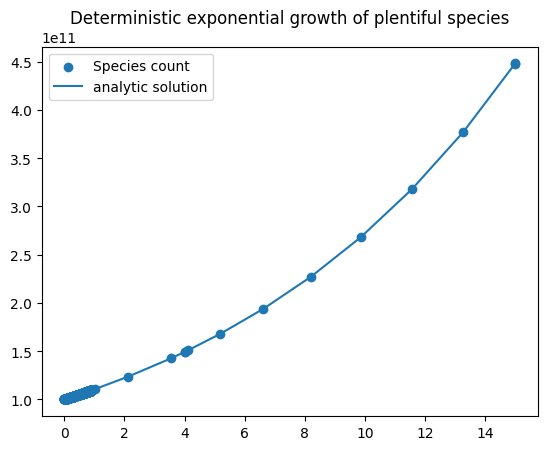

In [19]:
import matplotlib.pyplot as plt

plt.scatter(result.t_history, result.y_history[0,:].T)
plt.plot(result.t_history, y0[0] * np.exp(result.t_history * 0.1))
plt.title("Deterministic exponential growth of plentiful species")
plt.legend(['Species count', 'analytic solution'])

Text(0.5, 1.0, 'Stochastic birth death process for scarce species')

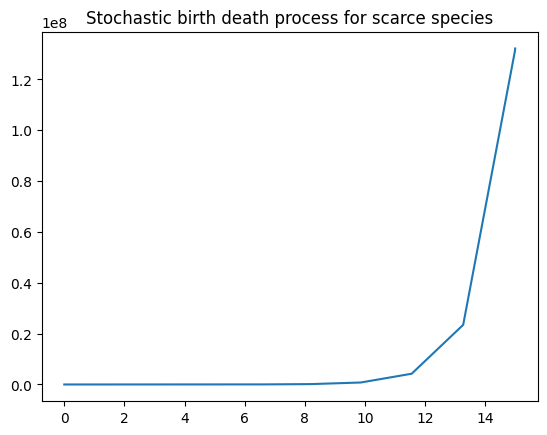

In [20]:
plt.plot(result.t_history, result.y_history[1,:].T)
plt.title("Stochastic birth death process for scarce species")

# Rescue mutant

In [21]:
seed = None
if seed is not None:
    rng = np.random.default_rng(seed)
else:
    rng = np.random.default_rng()

y0 = np.array([
    10e8, # target cells
    10e1,  # wildtype infected cells
    0,     # mutant infected cells
])

# it's more natural to write down the reactions and then transpose (so that the rows of the final matrix refer to a species and the columns refer to reactions)
N = np.array([
    [0,-1,0], # death of wildtype
    [0,0,-1], # death of mutant
    [-1,1,0], # infection --> new wildtypes (by wildtype)
    [-1,0,1], # infection --> mutation into mutant (by wildtype)
    [-1,0,1], # infection --> new mutants
]).T

rate_involvement_matrix = np.array([
    [0,1,0],
    [0,0,1],
    [1,1,0],
    [1,1,0],
    [1,0,1],
]).T

R0 = 0.8   # wildtype is dying out
d  = 10    # death rate for wild type per day
beta = R0 * d / (y0[0]) # beta derived from above two
mu = 0.001 # rare mutations can save it
dmu = 2 # mutant dies less
Rmu = beta * y0[0] / dmu
assert np.isclose(Rmu, R0 * d/dmu) # Rmu should be x times bigger where x is d/dmu

def rescue_probability(R0, Rmu, mu, y0):
    return 1 - np.exp((mu*R0*(1-1/Rmu)*y0[1])/(R0-1))

@jit(nopython=True)
def k_of_t(t):
    return np.array([d, dmu, beta, beta*mu, beta])

1 - rescue_probability(R0, Rmu, mu, y0)

0.7408182206817178

In [23]:
extinctions = 0
for i in range(1000):
    result = hybrid.forward_time(y0, [0, 15.0], k_of_t, N, rate_involvement_matrix, rng, partition_function=hybrid.FixedThresholdPartitioner(1000).partition_function)
    extinctions += result.y[-1] == 0.0
    print("i", i, "Exctinctions:", extinctions, "extinction probability:", extinctions/(i+1))
print("Expected extinction probability:", 1-rescue_probability(R0, Rmu, mu, y0))

i 0 Exctinctions: 1 extinction probability: 1.0
i 1 Exctinctions: 2 extinction probability: 1.0
i 2 Exctinctions: 2 extinction probability: 0.6666666666666666
i 3 Exctinctions: 3 extinction probability: 0.75
i 4 Exctinctions: 4 extinction probability: 0.8
i 5 Exctinctions: 4 extinction probability: 0.6666666666666666
i 6 Exctinctions: 5 extinction probability: 0.7142857142857143
i 7 Exctinctions: 6 extinction probability: 0.75
i 8 Exctinctions: 7 extinction probability: 0.7777777777777778
i 9 Exctinctions: 8 extinction probability: 0.8
i 10 Exctinctions: 9 extinction probability: 0.8181818181818182
i 11 Exctinctions: 10 extinction probability: 0.8333333333333334
i 12 Exctinctions: 11 extinction probability: 0.8461538461538461
i 13 Exctinctions: 12 extinction probability: 0.8571428571428571
i 14 Exctinctions: 13 extinction probability: 0.8666666666666667
i 15 Exctinctions: 14 extinction probability: 0.875
i 16 Exctinctions: 14 extinction probability: 0.8235294117647058
i 17 Exctinctions

KeyboardInterrupt: 

In [24]:
print("Expected extinction probability:", 1-rescue_probability(R0, Rmu, mu, y0))

Expected extinction probability: 0.7408182206817178
